# Design via Frequency Response
---

In [1]:
import sys

if (path := "C:/Users/Tom/pycharm-projects/python-control") not in sys.path:
    sys.path.append(path)

from python_control import (
    s, TransferFunction,
    get_damping_ratio,
    ClosedLoopTransientResponse,
    OpenLoopFrequencyResponse,
    ClosedLoopFrequencyResponse,
    FeedbackSystem,
    plot_bode_diagrams
)
from python_control.design.frequency_response import (
    gain_adjustment_for_phase_margin,
    create_lag_compensator,
    get_open_loop_gain,
    create_lead_compensator,
    create_lag_lead_compensator
)

## 11.2 : Transient Response via Gain Adjustment

### Example 11.1 : Transient Response Design via Gain Adjustment

For the position control system shown below, find the value of preamplifier gain $K$ to yield a 9.5% overshoot in the transient response for a step input.

![system for example 11.1](./images/example_11-1.png)

**Create the system's open-loop transfer function and get its frequency response**

> Ignore the individual gains of the transfer functions that make up the open-loop transfer function of the feedback system. This means it must be assumed that all gains are equal to 1. 

In [2]:
G1 = TransferFunction(1 / (s + 100))
G2 = TransferFunction(1 / (s + 36))
G3 = TransferFunction(1 / s)
G = G1 * G2 * G3

G_jw = OpenLoopFrequencyResponse(G)

**Determine the required phase-margin to meet the transient response requirement**

Get the damping ratio that corresponds with the required percent overshoot.

In [3]:
zeta = get_damping_ratio(percent_overshoot=9.5)
print(f"required damping ratio = {zeta}")

required damping ratio = 0.5996223335119943


Get the phase margin that corresponds with the required damping ratio.

In [4]:
CLTR_obj = ClosedLoopTransientResponse.solve(zeta=zeta)
print(f"required phase margin = {CLTR_obj.phi_m}°")

required phase margin = 59.16212044707338°


**Determine the required open-loop gain $K$ to get the required phase-margin** 

In [5]:
K, omega = gain_adjustment_for_phase_margin(
    phi_m_req=CLTR_obj.phi_m,
    G_jw=G_jw,
)
print(f"required open-loop gain = {K:.0f}")
print(f"frequency at which the required phase margin occurs = {omega:.2f} rad/s")

required open-loop gain = 58404
frequency at which the required phase margin occurs = 14.84 rad/s


**Determine the required gain of the preamplifier**

Only from this stage onwards do we have to take into account the gains of the individual transfer functions.

In [6]:
K1 = 100
K2 = 1
K3 = 1

We get the required gain of the preamplifier by dividing the required overall open-loop gain by the product of the gains of the individual transfer functions: 

In [7]:
K_preamp = K / (K1 * K2 * K3)
print(f"required preamplifier gain = {K_preamp:.2f}")

required preamplifier gain = 584.04


**Bode Diagram of the open-loop transfer function with the required open-loop gain $K$**

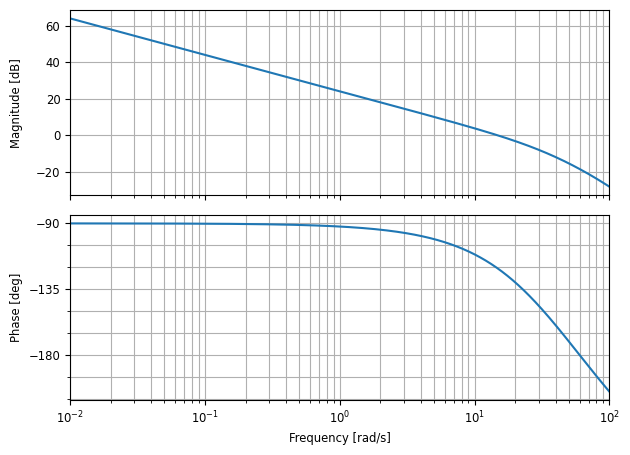

In [8]:
G_jw.bode_plot(K, wrap_phase=False, omega_limits=(0.01, 100))

## 11.3 : Lag Compensation

### Example 11.2 : Lag Compensation Design

For the system in the previous example, design a lag compensator to yield a tenfold improvement in steady-state error over the gain-compensated system while keeping the percent overshoot at 9.5 %.

If we look at the system, we see that the system is of type 1 (one pure integrator in the denominator). To improve the steady-state error, the velocity constant needs to be enlarged by a factor of 10, which implies that the open-loop gain must also be enlarged by a factor of 10.

In [9]:
feedback_system = FeedbackSystem(K * G)
print(f"- type of system = {feedback_system.system_type}")
print(f"- velocity error constant = {feedback_system.Kv}")

- type of system = type_1
- velocity error constant = 16.22337727167864


**Determine the required open-loop gain $K$ to meet the steady-state error requirement**

In [10]:
K_cs = 10 * K
print(f"required open-loop gain = {K_cs:.0f}")

required open-loop gain = 584042


**Design the lag compensator to meet the transient response requirement**

In [11]:
G_c = create_lag_compensator(
    phi_m_req=CLTR_obj.phi_m,
    K_req=K_cs,
    G_jw=G_jw
)
G_c.expr.factor(s)

0.0629473037092141*(1.0*s + 0.980614116849966)/(1.0*s + 0.0617270146348976)

**Bode diagram of lag compensator**

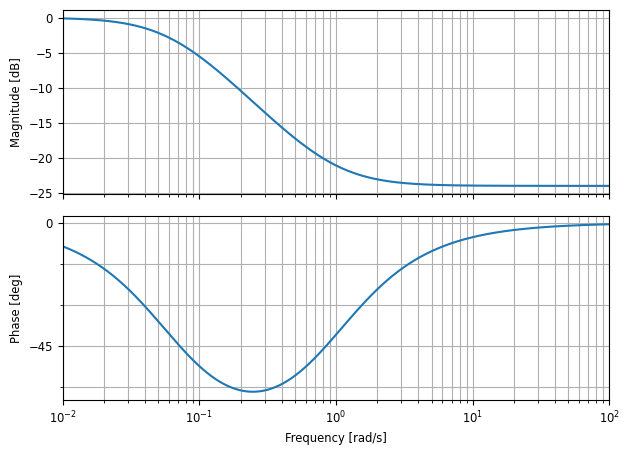

In [12]:
G_c_jw = OpenLoopFrequencyResponse(G_c)
G_c_jw.bode_plot(K=G_c_jw.transfer_function.gain, omega_limits=(0.01, 100))

**Bode diagram of the compensated system**

Open-loop transfer function of the lag-compensated system:

In [13]:
KG_cs = K_cs * G * G_c

To draw the Bode diagram of the compensated system, we need to create the frequency response of its transfer function. Keep in mind that when instantiating an `OpenLoopFrequencyResponse` object with a transfer function, the gain of this transfer function is ignored inside the `OpenLoopFrequencyResponse` object. Therefore, to draw the correct Bode diagram of the compensated system, we also need to specify the gain of its transfer function.

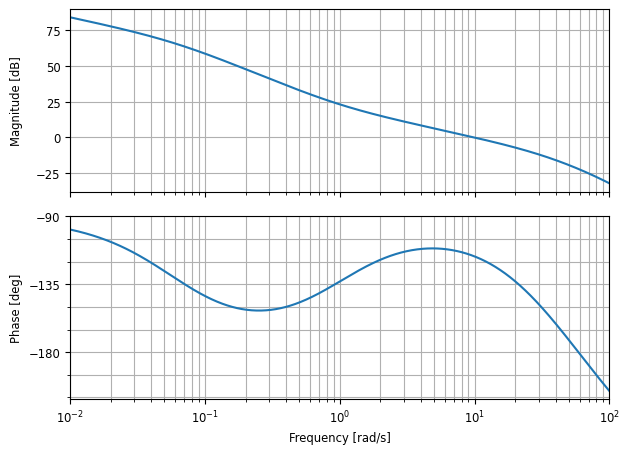

In [14]:
G_cs_jw = OpenLoopFrequencyResponse(KG_cs)
G_cs_jw.bode_plot(KG_cs.gain, omega_limits=(0.01, 100), wrap_phase=False)

Comparison of the Bode diagrams of the uncompensated and lag-compensated open-loop transfer functions. 

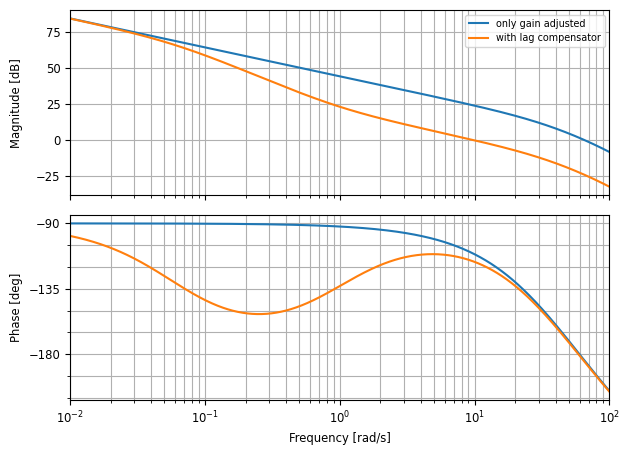

In [15]:
# transfer function of uncompenasated system, only with gain adjustment
KG = K_cs * G

plot_bode_diagrams(
    [KG, KG_cs],  # list of `TransferFunction` objects
    omega_limits=(0.01, 100),
    names=['only gain adjusted', 'with lag compensator'],
    wrap_phase=False,
    title='',
    legend_loc='upper right'
)

## 11.4 : Lead Compensation

### Example 11.3 : Lead Compensation Design

Given the system of example 11.1, design a lead compensator to yield a 20% overshoot and $K_v$ = 40, with a peak time of 0.1 second.

**Transient response requirements**

- Percent overshoot determines the damping ratio, and damping ratio determines the required phase margin.
- Peak time determines the closed-loop bandwidth frequency. 

In [16]:
zeta = get_damping_ratio(20)
CLTR_obj = ClosedLoopTransientResponse.solve(zeta=zeta, T_p=0.1)

print(f"required closed-loop bandwidth = {CLTR_obj.omega_bdw:.1f} rad/s")
print(f"required phase margin = {CLTR_obj.phi_m:.1f}°")

required closed-loop bandwidth = 46.6 rad/s
required phase margin = 48.1°


**Steady-state error requirement**

In [17]:
K_req = get_open_loop_gain(40.0, G_jw)

print(f"required open-loop gain = {K_req:.0f}")

required open-loop gain = 144000


**Design lead compensator**

In [18]:
G_c = create_lead_compensator(CLTR_obj.phi_m, K_req, G_jw)
G_c.expr

(2.37940348304628*s + 60.1498994437654)/(1.0*s + 60.1498994437654)

Check the closed-loop bandwidth of the lead-compensated system with its requirement.

In [19]:
feedback_system = FeedbackSystem(
    K_req * G * G_c,
    name='lead-compensated feedback system'
)
T_jw_cs = ClosedLoopFrequencyResponse(feedback_system)

print(f"closed-loop bandwidth = {T_jw_cs.get_bandwidth_frequency()} rad/s")

closed-loop bandwidth = 68.83201810038123 rad/s


Since this bandwidth exceeds the requirement, we can assume the peak time specification is met.

**Bode diagram of lead compensator**

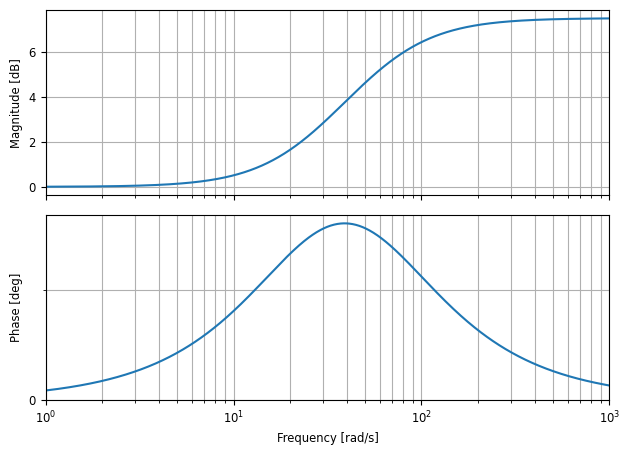

In [20]:
G_c_jw = OpenLoopFrequencyResponse(G_c)
G_c_jw.bode_plot(K=G_c_jw.transfer_function.gain, omega_limits=(1, 1000))

**Bode diagram of the uncompensated system's and lead-compensated system's open-loop transfer function**

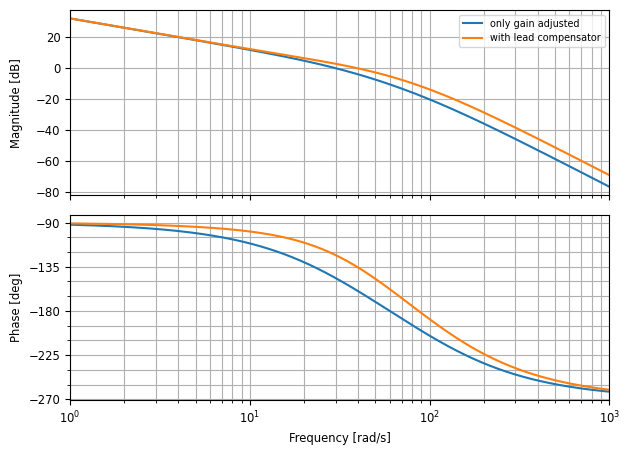

In [21]:
plot_bode_diagrams(
    [K_req * G, K_req * G_c * G],
    omega_limits=(1, 1000),
    names=['only gain adjusted', 'with lead compensator'],
    wrap_phase=False,
    title='',
    legend_loc='upper right'
)

## 11.5 : Lag-Lead Compensation

### Example 11.4 : Lag-Lead Compensation Design

Given a unity-feedback system where
$$
G\left( s \right) = \frac{K}{{s\left( {s + 1} \right)\left( {s + 4} \right)}}
$$
design a passive lag-lead compensator using Bode diagrams to yield a 13.25% overshoot, a peak time of 2 seconds, and $K_v$ = 12.

**Create the open-loop transfer function and its frequency response**

In [23]:
G = TransferFunction(1 / (s * (s + 1) * (s + 4)))
G_jw = OpenLoopFrequencyResponse(G)

**Determine closed-loop transient response requirements**

In [24]:
zeta = get_damping_ratio(percent_overshoot=13.25)
CLTR_obj = ClosedLoopTransientResponse.solve(zeta=zeta, T_p=2.0)

print(
    f"required closed-loop bandwidth = {CLTR_obj.omega_bdw:.2f} rad/s",
    f"required phase margin = {CLTR_obj.phi_m:.2f}°",
    sep='\n'
)

required closed-loop bandwidth = 2.29 rad/s
required phase margin = 55.02°


**Determine required open-loop gain from steady-state error requirements**

In [25]:
K = get_open_loop_gain(12.0, G_jw)

print(f"required open-loop gain = {K:.0f}")

required open-loop gain = 48


**Design the lag-lead compensator**

Select the phase-margin frequency near the required closed-loop bandwidth frequency:

In [26]:
omega_phi_m = 1.8

G_c = create_lag_lead_compensator(
    phi_m_req=CLTR_obj.phi_m,
    K_req=K,
    G_jw=G_jw,
    omega_phi_m=omega_phi_m,
    phi_m_compensation=5.0
)
G_c.expr

(1.0*s**2 + 0.744221492340776*s + 0.10155986862134)/(1.0*s**2 + 5.76011158626189*s + 0.10155986862134)

**Check the final closed-loop bandwidth to be sure that the speed requirement has been met**

In [27]:
feedback_system = FeedbackSystem(K * G_c * G)
T_jw = ClosedLoopFrequencyResponse(feedback_system)

print(
    f"actual closed-loop bandwidth: "
    f"{T_jw.get_bandwidth_frequency(omega_limits=(0.01, 100))} rad/s"
)

actual closed-loop bandwidth: 3.1095597879848067 rad/s


This bandwidth exceeds that required to meet the peak time requirement.

**Bode diagram of lag-lead compensator**

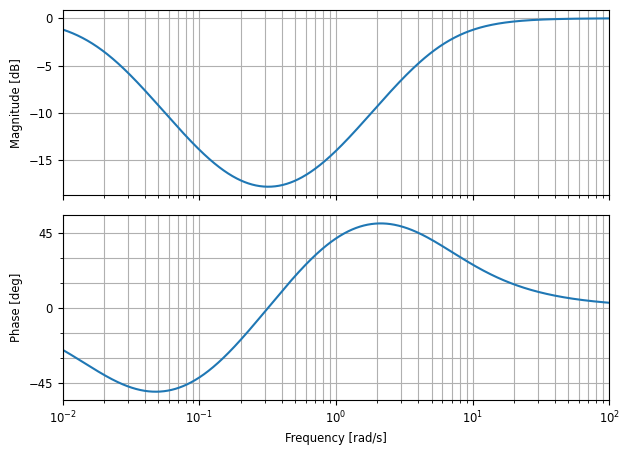

In [31]:
G_c_jw = OpenLoopFrequencyResponse(G_c)
G_c_jw.bode_plot(omega_limits=(0.01, 100))

**Bode diagram of the uncompensated system's and lead-compensated system's open-loop transfer function**

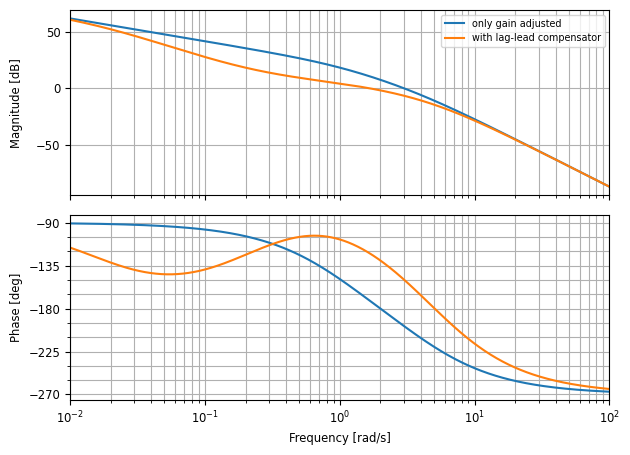

In [33]:
plot_bode_diagrams(
    [K * G, K * G_c * G],
    omega_limits=(0.01, 100),
    names=['only gain adjusted', 'with lag-lead compensator'],
    wrap_phase=False,
    title='',
    legend_loc='upper right'
)